In [2]:
import re
import numpy as np
np.set_printoptions(threshold=np.inf)

# function to split a line into objects by whitespaces
def ws_split(lst):
    lst = re.split(r'\s+', lst)
    lst.pop()        #remove first empty character
    lst.pop(0)       #remove last empty character
    return lst

def ws_split_int(lst):
    lst = re.split(r'\s+', lst)
    lst.pop()        #remove first empty character
    lst.pop(0)       #remove last empty character
    lst = [int(x) for x in lst]
    return lst

def instance_read(instance):
    with open(instance) as f:
        lines = f.readlines()
    d = dict();
    d['ref'] = lines[0]
    num_of_vars = d['num_of_vars'] = int(lines[1])
    d['profits'] = np.asarray(ws_split_int(lines[2]))
    combinations = [ws_split_int(i) for i in lines[3:num_of_vars+2]]
    combi_length = max(map(len, combinations))
    d['combinations'] = np.array([[0]*(combi_length-len(xi))+xi for xi in combinations])
    d['constraint_type'] = lines[int(num_of_vars)+3]
    weights = np.asarray(ws_split_int(lines[num_of_vars+5]))
    d['weights'] = weights
    
    d['capacity'] = 0.8 * sum(weights)
        
    return d


####
# available keys: ref (instance reference) 
# num_of_vars (n)
# profits (p_i)
# combinations (p_ij)
# constraint_type
# capacity (C_k)
# weights (w_i)
####
num_kp = 3

instance = instance_read('jeu_100_25_1.txt')
num_of_vars = instance.get("num_of_vars")
profits = instance.get("profits")
combinations = instance.get("combinations")
constraint_type = instance.get("constraint_type")
capacity = instance.get("capacity") / num_kp
weights = instance.get("weights")

ou will use ALL the data sets foundherehttps://cedric.cnam.fr/~soutif/QKP/QKP.htmlin your analysis with the modi cation that thenumber of knapsacksM23;5;10 and for each problem instance the capacity of each knapsack is set to80% of the sum of all item weights divided by the number of knapsack

In [5]:
import math
import time, array, random, copy, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from deap import algorithms, base, benchmarks, tools, creator

def instance_create(instance, m, pop_size, num_gen, mut_rate, xover_rate):
    with open(instance) as f:
        lines = f.readlines()
    d = dict();
    d['ref'] = lines[0]
    num_of_vars = d['num_of_vars'] = int(lines[1])
    d['profits'] = np.asarray(ws_split_int(lines[2]))
    combinations = [ws_split_int(i) for i in lines[3:num_of_vars+2]]
    combi_length = max(map(len, combinations))
    d['combinations'] = np.array([[0]*(combi_length-len(xi))+xi for xi in combinations])
    d['constraint_type'] = lines[int(num_of_vars)+3]
    weights = np.asarray(ws_split_int(lines[num_of_vars+5]))
    d['weights'] = weights    
    d['capacity'] = math.floor((0.8 * sum(weights)) / m)
    d['mut_rate'] = mut_rate
    d['xover_rate'] = xover_rate
    d['num_gen'] = num_gen
    d['pop_size'] = pop_size
    d['n_kp'] = m
    return d
def mutation(x, instance):
    if instance == None:
        raise ValueError("No Instance Passed into Mutation Function")
    n = len(x)
    m = int(instance.get("n_kp"))
    index = random.randrange(0,n)
    var = random.randint(0,m)
    x[index] = var
    return x, 
def uniform(low, m, n_kp):
    n = []
    for i in range(0,m):
        n.append(random.randint(0,n_kp))
    return n
def eval_fitness(individual, instance):
    #global instance
    m = max(individual)
    num_of_vars = instance.get("num_of_vars")
    profits = instance.get("profits")
    combinations = instance.get("combinations")
    constraint_type = instance.get("constraint_type")
    capacity = int(instance.get("capacity"))
    weights = instance.get("weights")
    knapsacks_weight = [0]*m
    knapsacks_profit = [0]*m

    for i in range(len(individual)):
        if individual[i] != 0:
            knapsacks_weight[individual[i]-1] += weights[i]
            knapsacks_profit[individual[i]-1] += profits[i]
            for j in range(len(individual)):
                if individual[i] == individual[j]:
                    knapsacks_profit[individual[i]-1] += combinations[i-1][j-1]
    f1 = 0
    f2 = sum(knapsacks_weight)

    for i in range(m):
        if knapsacks_weight[i] > capacity:
            f1 += knapsacks_profit[i] * (capacity / knapsacks_weight[i])
        else:
            f1 += knapsacks_profit[i]
    f1 += m * min(knapsacks_profit)
    return f1, f2
def favorite_child_xover(ind1, ind2):
    fit1 = ind1.fitness.values
    fit2 = ind2.fitness.values

    prob = fit1[0] / (fit1[0]+fit2[0])

    if fit1[0] > fit2[0]:
        prob = 1/prob

    size = min(len(ind1), len(ind2))

    for i in range(size):
        if random.random() > prob:
            ind1[i] = ind2[i]
            ind2[i] = ind1[i]
    return ind1, ind2
def run_ea(toolbox, stats=None, verbose=False):
    pop = toolbox.population(n=toolbox.pop_size)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("max", np.max)
    stats.register("avg", np.mean)
    population, logbook = algorithms.eaMuPlusLambda(pop, toolbox, mu=toolbox.pop_size, 
                                     lambda_=toolbox.pop_size, 
                                     cxpb=1-toolbox.mut_prob,
                                     mutpb=toolbox.mut_prob, 
                                     stats=stats, 
                                     ngen=toolbox.max_gen, 
                                     verbose=True)
    return population, logbook
def ea_execution(instance):
    ## Set up problem
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,1.0))
    creator.create("Individual", list, typecode='i', fitness=creator.FitnessMin)
    ## Register Functions and Create Toolbox
    toolbox = base.Toolbox()
    ## General parameters
    toolbox.max_gen = instance.get("num_gen")
    toolbox.mut_prob = instance.get("mut_rate")
    toolbox.cx_prob = instance.get("xover_rate")
    ## Generating Population
    toolbox.pop_size = instance.get('pop_size')    
    toolbox.register("attr_float", uniform, 0, instance.get("num_of_vars"), num_kp)
    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    ## Evaluating Fitness
    toolbox.register("evaluate", lambda x: eval_fitness(x, instance))
    ## Mutation
    toolbox.register("mutate", lambda x: mutation(x, instance))
    ## Xover
    toolbox.register("mate", favorite_child_xover)
    ## Selection
    toolbox.register("select", tools.selNSGA2)
    %time res,_ = run_ea(toolbox)
    fronts = tools.emo.sortLogNondominated(res, len(res))
    plot_colors = seaborn.color_palette("Set1", n_colors=10)
    fig, ax = plt.subplots(1, figsize=(4,4))
    for i,inds in enumerate(fronts):
        par = [toolbox.evaluate(ind) for ind in inds]
        df = pd.DataFrame(par)
        df.plot(ax=ax, kind='scatter', label='Front ' + str(i+1), 
                     x=df.columns[0], y=df.columns[1], 
                     color=plot_colors[i])
    plt.xlabel('$f_1(\mathbf{x})$');plt.ylabel('$f_2(\mathbf{x})$');

instance = instance_create('jeu_100_25_1.txt', 3, 500, 50, .05, .8)
ea_execution(instance)

gen	nevals	max    	avg    
0  	500   	35065.2	12861.1
1  	500   	35258  	12719.1
2  	500   	35258  	12688.8
3  	500   	35258  	12722.8
4  	500   	34171.1	12351.2
5  	500   	34171.1	12557.7
6  	500   	36943.8	12724.2
7  	500   	34063  	12886.7
8  	500   	36268.4	13358.5
9  	500   	36852.8	13035.9
10 	500   	36551.7	13084.7
11 	500   	36551.7	12542  
12 	500   	37452.8	13462.9
13 	500   	38657.3	13049.5
14 	500   	39380.3	12664  
15 	500   	40249  	12946.9
16 	500   	40249  	12789.6
17 	500   	40249  	12880.7
18 	500   	40116.7	13044.4
19 	500   	38363.3	12586.9
20 	500   	38363.3	11962.1
21 	500   	38363.3	12567  
22 	500   	37552  	12559.9
23 	500   	39937.9	12033.1
24 	500   	39937.9	11570.3
25 	500   	39937.9	11413.7
26 	500   	39937.9	11148.2
27 	500   	39937.9	11728.9
28 	500   	37488.9	10840.6
29 	500   	32653.6	10807.7
30 	500   	31082.4	10871.6
31 	500   	29628.6	10626  
32 	500   	26697.2	10150  
33 	500   	24225.9	9889.88
34 	500   	23526.1	9466.14
35 	500   	23331.9	9526.74
3

NameError: name 'res' is not defined

C:\ProgramData\Anaconda3\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	max    	avg    
0  	500   	34431.1	12866.4
1  	500   	34431.1	11118.9
2  	500   	36732.8	9506.46
3  	500   	36732.8	8613.89
4  	500   	33939.3	7614.94
5  	500   	33939.3	7766.38
6  	500   	32309.8	7638.12
7  	500   	32021.1	7658.41
8  	500   	33629.9	7518.11
9  	500   	33629.9	7077.39
10 	500   	24626.3	7030.12
11 	500   	17368.1	6855.97
12 	500   	16853.3	6700.95
13 	500   	17635.3	6621.7 
14 	500   	17635.3	6613.98
15 	500   	17662.9	6509.16
16 	500   	16842.2	6412.12
17 	500   	16094.9	6395.94
18 	500   	15842.1	6400.88
19 	500   	15293.1	6303.42
20 	500   	15156.1	6231.3 
21 	500   	15014.1	6211.89
22 	500   	15014.1	5967.78
23 	500   	15095.4	5903.05
24 	500   	15095.4	5818.31
25 	500   	15014.1	5706.31
26 	500   	14523  	5695.72
27 	500   	14346.6	5661.15
28 	500   	14317.6	5624.97
29 	500   	14228.8	5446.07
30 	500   	13994.5	5383.35
31 	500   	13908  	5343.12
32 	500   	13787.1	5198.2 
33 	500   	13685.8	5041.29
34 	500   	13597  	5002.83
35 	500   	13385.3	5097.54
3

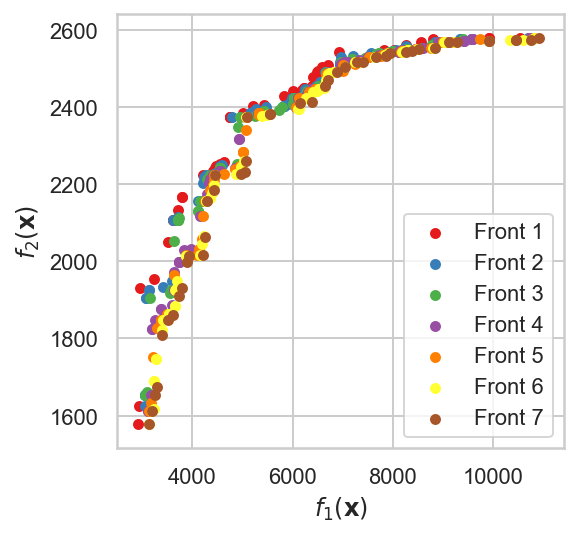

In [6]:
import time, array, random, copy, math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn
seaborn.set(style='whitegrid')
seaborn.set_context('notebook')

from deap import algorithms, base, benchmarks, tools, creator


def eval_fitness(individual):
    global instance
    m = max(individual)
    
    num_of_vars = instance.get("num_of_vars")
    profits = instance.get("profits")
    combinations = instance.get("combinations")
    constraint_type = instance.get("constraint_type")
    capacity = int(instance.get("capacity"))
    weights = instance.get("weights")
    knapsacks_weight = [0]*m
    knapsacks_profit = [0]*m
    
    for i in range(len(individual)):
        if individual[i] != 0:
            knapsacks_weight[individual[i]-1] += weights[i]
            knapsacks_profit[individual[i]-1] += profits[i]
            for j in range(len(individual)):
                if individual[i] == individual[j]:
                    knapsacks_profit[individual[i]-1] += combinations[i-1][j-1]
    f1 = 0
    f2 = sum(knapsacks_weight)

    for i in range(m):
        if knapsacks_weight[i] > capacity:
            f1 += knapsacks_profit[i] * (capacity / knapsacks_weight[i])
        else:
            f1 += knapsacks_profit[i]
    f1 += m * min(knapsacks_profit)
    return f1, f2

def uniform(low, m, n_kp):
    n = []
    for i in range(0,m):
        n.append(random.randint(0,n_kp))
    return n

def favorite_child_xover(ind1, ind2):
    fit1 = ind1.fitness.values
    fit2 = ind2.fitness.values
    
    prob = fit1[0] / (fit1[0]+fit2[0])
    
    if fit1[0] > fit2[0]:
        prob = 1/prob
    
    size = min(len(ind1), len(ind2))
    
    for i in range(size):
        if random.random() > prob:
            ind1[i] = ind2[i]
            ind2[i] = ind1[i]
    return ind1, ind2

def mutation(x):
    index = random.randrange(len(x))
    var = random.randint(0,len(x))
    x[index] = var
    return x,

creator.create("FitnessMin", base.Fitness, weights=(-1.0,1.0))
creator.create("Individual", list, typecode='i', 
               fitness=creator.FitnessMin)

toolbox = base.Toolbox()


BOUND_LOW, BOUND_UP = 0, instance.get("num_of_vars")
NDIM = 2
toolbox.register("evaluate", eval_fitness)

toolbox.register("attr_float", uniform, BOUND_LOW, BOUND_UP, num_kp)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
#toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0)
toolbox.register("mate", favorite_child_xover)
#toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0, indpb=1.0/NDIM)
toolbox.register("mutate", mutation,)
toolbox.register("select", tools.selNSGA2)

toolbox.pop_size = 500
toolbox.max_gen = 50
toolbox.mut_prob = 0.5

def run_ea(toolbox, stats=None, verbose=False):
    pop = toolbox.population(n=toolbox.pop_size)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("max", np.max)
    stats.register("avg", np.mean)
    population, logbook = algorithms.eaMuPlusLambda(pop, toolbox, mu=toolbox.pop_size, 
                                     lambda_=toolbox.pop_size, 
                                     cxpb=1-toolbox.mut_prob,
                                     mutpb=toolbox.mut_prob, 
                                     stats=stats, 
                                     ngen=toolbox.max_gen, 
                                     verbose=True)
    return population, logbook

%time res,_ = run_ea(toolbox)

fronts = tools.emo.sortLogNondominated(res, len(res))

plot_colors = seaborn.color_palette("Set1", n_colors=10)
fig, ax = plt.subplots(1, figsize=(4,4))
for i,inds in enumerate(fronts):
    par = [toolbox.evaluate(ind) for ind in inds]
    df = pd.DataFrame(par)
    df.plot(ax=ax, kind='scatter', label='Front ' + str(i+1), 
                 x=df.columns[0], y=df.columns[1], 
                 color=plot_colors[i])
plt.xlabel('$f_1(\mathbf{x})$');plt.ylabel('$f_2(\mathbf{x})$');

In [70]:
import random
individual = []
m = random.randint(1,num_of_vars)            #number of knapsacks

for i in range(0,num_of_vars):
    n = random.randint(0,m)
    individual.append(n)

knapsack_capacity = capacity
def feature_transform(integer_representation):
    n = len(integer_representation)
    m = max(integer_representation)
    if min(integer_representation) < 0:
        raise ValueError("One of the items is in a negative knapsack, which doesn't make sense")
    binary_matrix = np.zeros((m,n))
    for i in range(n):
        if not integer_representation[i] == 0:
            binary_matrix[integer_representation[i]-1, i] = 1
    idx = np.argwhere(np.all(binary_matrix[..., :] == 0, axis=1))
    a2 = np.delete(binary_matrix, idx, axis=0)
    return feature_revert(a2)
def feature_revert(binary_matrix):
    n = binary_matrix.shape[1]
    m = binary_matrix.shape[0]
    sol = [0] * binary_matrix.shape[1]
    result = (binary_matrix.T @ np.arange(1,m+1)).astype(int)
    return result.tolist()
def fitness_eval(individual, instance):
    individual = feature_transform(individual)
    m = int(max(individual))
    num_of_vars = instance.get("num_of_vars")
    profits = instance.get("profits")
    combinations = instance.get("combinations")
    constraint_type = instance.get("constraint_type")
    capacity = int(instance.get("capacity"))
    weights = instance.get("weights")
    knapsacks_weight = [0]*m
    knapsacks_profit = [0]*m
    for i in range(len(individual)):
        if individual[i] != 0:
            knapsacks_weight[individual[i]-1] += weights[i]
            knapsacks_profit[individual[i]-1] += profits[i]
            for j in range(len(individual)):
                if individual[i] == individual[j]:
                    knapsacks_profit[individual[i]-1] += combinations[i-1][j-1]
    f1 = 0
    f2 = sum(knapsacks_weight)
    for i in range(m):
        if knapsacks_weight[i] > capacity:
            f1 += knapsacks_profit[i] * (capacity / knapsacks_weights[i])
        else:
            f1+= knapsacks_profit[i]
    f1 += m * min(knapsacks_profit)
    return f1, f2
fitness_eval(individual, instance)

### Command for adding fitness function:
## toolbox.register("evaluate", lambda x: fitness_eval(x, instance))


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


(9919, 2366)

In [1]:
import time, array, random, copy, math
import numpy as np
import pandas as pd
from random import sample

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn
seaborn.set(style='whitegrid')
seaborn.set_context('notebook')

from deap import algorithms, base, benchmarks, tools, creator

random.seed(a=42)

creator.create("FitnessMin", base.Fitness, weights=(-1.0,-1.0))
creator.create("Individual", array.array, typecode='d', fitness=creator.FitnessMin)

def dent(individual, lbda = 0.85):
    """ 
    Implements the test problem Dent
    Num. variables = 2; bounds in [-1.5, 1.5]; num. objetives = 2.
    @author Cesar Revelo
    """
    d  = lbda * math.exp(-(individual[0] - individual[1]) ** 2)  
    f1 = 0.5 * (math.sqrt(1 + (individual[0] + individual[1]) ** 2) + \
                math.sqrt(1 + (individual[0] - individual[1]) ** 2) + \
                individual[0] - individual[1]) + d
    f2 = 0.5 * (math.sqrt(1 + (individual[0] + individual[1]) ** 2) + \
                math.sqrt(1 + (individual[0] - individual[1]) ** 2) - \
                individual[0] + individual[1]) + d
    return f1, f2

toolbox = base.Toolbox()

BOUND_LOW, BOUND_UP = 0, 100
NDIM = 2
toolbox.register("evaluate", dent)

def uniform(low, up, size=None):
    try:
        return sample([*range(low, up+1, 1)], k=up)
    except TypeError:
        return [sample([*range(a, b+1, 1)], k=up) for a, b in zip([low] * size, [up] * size)]

toolbox.register("attr_float", uniform, BOUND_LOW, BOUND_UP, NDIM)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

num_samples = 50
limits = [np.arange(BOUND_LOW, BOUND_UP, (BOUND_UP - BOUND_LOW)/num_samples)] * NDIM
sample_x = np.meshgrid(*limits)

flat = []
for i in range(len(sample_x)):
    x_i = sample_x[i]
    flat.append(x_i.reshape(num_samples**NDIM))
    
example_pop = toolbox.population(n=num_samples**NDIM)

for i, ind in enumerate(example_pop):
    for j in range(len(flat)):
        ind[j] = flat[j][i]
        
fitnesses = toolbox.map(toolbox.evaluate, example_pop)
for ind, fit in zip(example_pop, fitnesses):
    ind.fitness.values = fit

def pareto_dominance(x,y):
    return tools.emo.isDominated(x.fitness.values, y.fitness.values)

dominated = [ind for ind in example_pop if pareto_dominance(a_given_individual, ind)]
dominators = [ind for ind in example_pop if pareto_dominance(ind, a_given_individual)]
others = [ind for ind in example_pop if not ind in dominated and not ind in dominators]

def plot_dent():
    'Plots the points in decision and objective spaces.'
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    for ind in dominators: plt.plot(ind[0], ind[1], 'r.')
    for ind in dominated: plt.plot(ind[0], ind[1], 'g.')
    for ind in others: plt.plot(ind[0], ind[1], 'k.', ms=3)
    plt.plot(a_given_individual[0], a_given_individual[1], 'bo', ms=6);
    plt.xlabel('$x_1$');plt.ylabel('$x_2$');
    plt.title('Decision space');
    plt.subplot(1,2,2)
    for ind in dominators: plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'r.', alpha=0.7)
    for ind in dominated: plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'g.', alpha=0.7)
    for ind in others: plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'k.', alpha=0.7, ms=3)
    plt.plot(a_given_individual.fitness.values[0], a_given_individual.fitness.values[1], 'bo', ms=6);
    plt.xlabel('$f_1(\mathbf{x})$');plt.ylabel('$f_2(\mathbf{x})$');
    plt.xlim((0.5,3.6));plt.ylim((0.5,3.6));
    plt.title('Objective space');
    plt.tight_layout()
    
plot_dent()

non_dom = tools.sortNondominated(example_pop, k=len(example_pop), first_front_only=True)[0]

plt.figure(figsize=(5,5))
for ind in example_pop:
    plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'k.', ms=3, alpha=0.5)
for ind in non_dom:
    plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'bo', alpha=0.74, ms=5)
plt.title('Pareto-optimal front')



NameError: name 'a_given_individual' is not defined